# Time to Upgrade?

A mobile telephone operator, Megaline, is looking to appeal their customers for its more premium plan subscription. 

The company wishes to build a model that predicts the potential of its existing customers to upgrade to the premium plan.

A dataset of their monthly usage of call, internet, and messaging services, as well as the subscription plan is provided. 

The model should have as high of accuracy level as possible, with minimum level of  0.75.

The observed data in the dataset are:
    
1. сalls — number of call

2. minutes — total duration of calls in minute

3. messages — number of text message

4. mb_used — internet traffic usage in MB

5. is_ultra — the current subscription plan (Ultra - 1, Smart - 0)

The start of this project is observing the dataset. It will be continued by making 3 models each using different algorithm. In the process of making each model, tuning will be done to find combination of hyperparameters that results in the highest validation metric, that in this case is accuracy score.

It will then be closed with sanity check, using other validation metrices than accuracy score.

## Data Observation

In [ ]:
# import libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# load dataset and samples of observed data
df = pd.read_csv('/content/gdrive/MyDrive/data_projects/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [ ]:
# load general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [ ]:
# load statistical description
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


## Exploratory Data Analysis

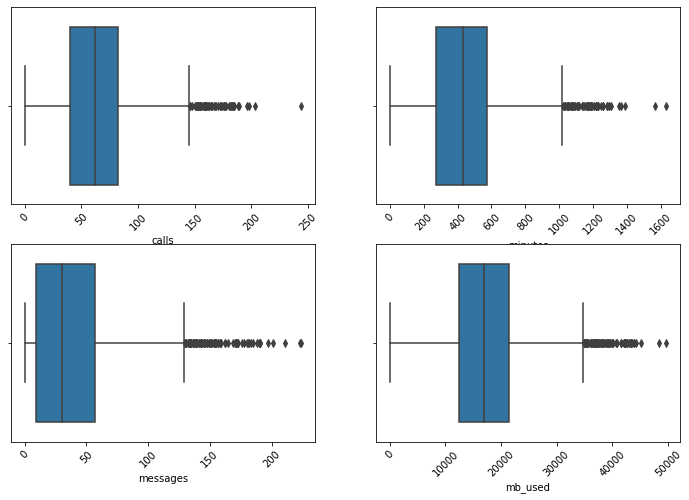

In [ ]:
# load boxplot
columns = ('calls', 'minutes', 'messages', 'mb_used')
plt.subplots(figsize = (12, 8))
for i, column in enumerate(columns):
    sns.boxplot(data=df, x=column, ax = plt.subplot(2, 2, i + 1))
    plt.xticks(rotation = 45)

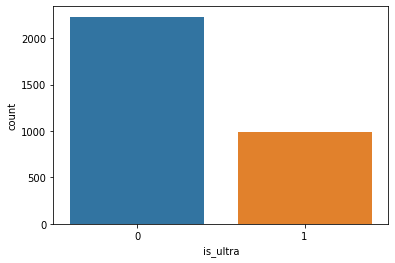

In [ ]:
# Univariate anlysis target
sns.countplot(df['is_ultra'])

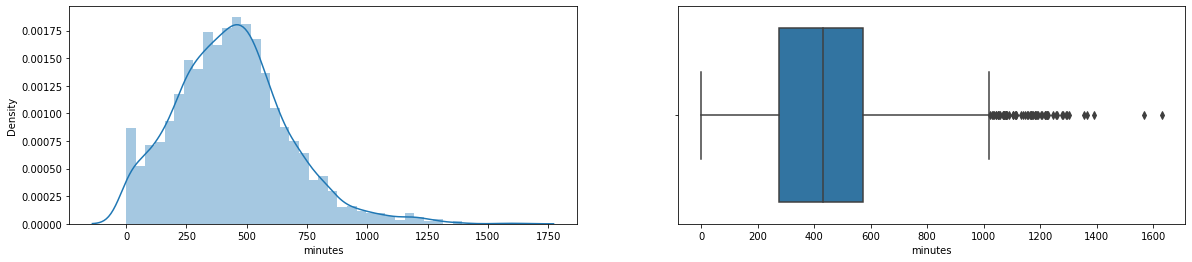

In [ ]:
# Univariate analysis minutes.
f = plt.figure(figsize=(20,4))
f.add_subplot(1,2,1)
sns.distplot(df['minutes'])

f.add_subplot(1,2,2)
sns.boxplot(df['minutes'])

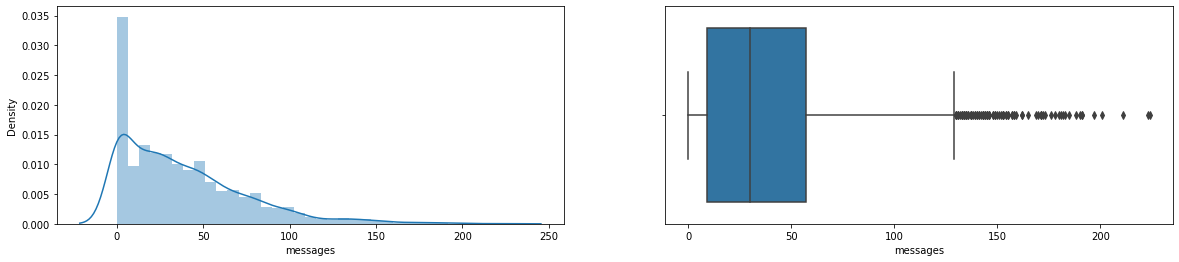

In [ ]:
# Univariate analysis messages.
f = plt.figure(figsize=(20,4))

f.add_subplot(1,2,1)
sns.distplot(df['messages'])

f.add_subplot(1,2,2)
sns.boxplot(df['messages'])

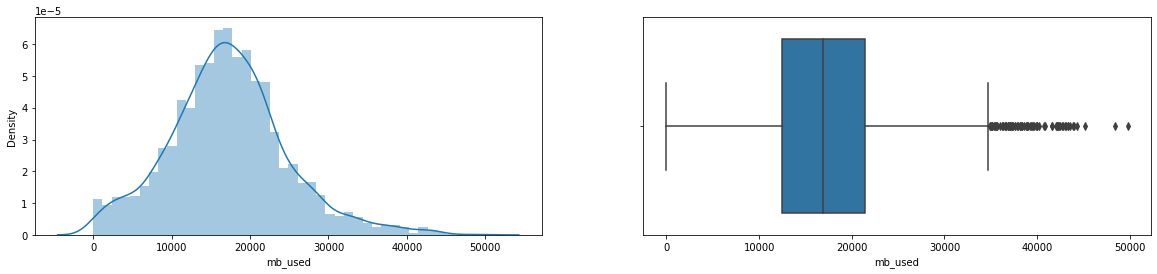

In [ ]:
# Univariate analysis mb_used.
f = plt.figure(figsize=(20,4))

f.add_subplot(1,2,1)
sns.distplot(df['mb_used'])

f.add_subplot(1,2,2)
sns.boxplot(df['mb_used'])

From data observation and exploratory data analysis, important informations are gained, that then inform whether there is a need to improve or manipulate the dataset.

Size of the dataset is 3,214 rows and 5 columns. 

Features columns are: calls, minutes, messages, and mb_used. 
They are all float data, as expected. 

While target column is is_ultra. It is boolean type of 0 and 1.

There is no missing values.

There is no negative values, as expected.

There are many outliers on all 4 features.

For minutes, data is centered on around 400 minutes.

For messages, data is centered on around 0 message.

For mb_used, data is centered on around 17,000 mb.

It is known that plan Surf includes maximum 500 minutes of call and 15GB(15,360 mb) of internet data.

While dataset is a little imbalance on proportion of the target, with around 70% of the observed data are Surf plan.

This means that although majority of users make use of call duration less than the Surf's monthly allotment, internet use is above the plan's allotment.

This also means that most of the subsribers bear additional cost for excess of internet data use.

Knowing that the dataset has high variance, there might be certain tuning of hyperparameters that needed in order to make the best model out of it. 

In the next step, the model will be start to built.

This is a supervised learning as the target is known, that is to determine if observed data will result in Ultra package or not. And so for that reason, obviously Classifier, instead of Regression, algorithm will be used to build the needed model.

Three algorithms will be used to make a model, and then tested to see which one results in the best validation metric given certain hyperparameters:

1. Decision Tree Classifier

2. Random Forest

3. Logistic Regression

## Data Splitting

In [ ]:
# Divide train-validation-test the dataset
df_train, df_val_test = train_test_split(df, test_size = 0.25, random_state =123)
df_val, df_test = train_test_split(df_val_test, test_size = 0.4, random_state =123)

In [ ]:
# Check the size of train dataset
df_train.shape

(2410, 5)

In [ ]:
# Check the size of validation dataset
df_val.shape

(482, 5)

In [ ]:
# Check the size of test dataset
df_test.shape

(322, 5)

In [ ]:
# slice the datasets each for independent and dependent variables
x_train = df_train.drop(['is_ultra'], axis=1)
y_train = df_train['is_ultra']
x_val = df_val.drop(['is_ultra'], axis=1)
y_val = df_val['is_ultra']
x_test = df_test.drop(['is_ultra'], axis=1)
y_test = df_test['is_ultra']

Data has been split, 75%, 15% and 10% for training, validation and testing, respectively.

## Decision Tree Classifier

A model using algorithm of decision tree classifier will be built. The best max depth hyperparameter will be found by looping the model from range 1 to 11.

In [ ]:
# Build model and loop for given max_depth hyperparameter with highest score of accuracy
for depth in range(1,12):
    D_Tree= DecisionTreeClassifier(random_state=123, max_depth=depth)
    D_Tree.fit(x_train, y_train)
    score_val = D_Tree.score(x_val, y_val)
    print("max_depth =", depth, ": ", end='')
    print(score_val)

max_depth = 1 : 0.7406639004149378
max_depth = 2 : 0.7883817427385892
max_depth = 3 : 0.7966804979253111
max_depth = 4 : 0.7966804979253111
max_depth = 5 : 0.7780082987551867
max_depth = 6 : 0.7966804979253111
max_depth = 7 : 0.8049792531120332
max_depth = 8 : 0.7966804979253111
max_depth = 9 : 0.8029045643153527
max_depth = 10 : 0.8070539419087137
max_depth = 11 : 0.7883817427385892


From the looping, it appears that, using validation dataset, as max_depth increases the accuracy increases as well, until max depth of 4, and the accuracy decreases. Hence for the final model the hyperparameter will be set at 4.

In [ ]:
# Build final model with max depth set at 10
D_Tree_final= DecisionTreeClassifier(random_state=123, max_depth=4)
D_Tree_final.fit(x_train, y_train)
score_test = D_Tree_final.score(x_test, y_test)
score_test

0.7919254658385093

In [ ]:
# check the model's score of accuracy if dataset used is train dataset
D_Tree_final.score(x_train, y_train)

0.7987551867219918

### Interim Conclusion

Using Decision Tree Classifier, with max_depth set at optimal of 4, the score of accuracy, using test dataset, is 0.79. This is already above the required score of 0.75.

The model is also used back to predict the train dataset. The score of accuracy for each dataset looks like this:

1. Train dataset: 0.798

2. Validation dataset: 0.796

3. Test dataset: 0.791

It seems that the model is not overfitting nor underfitting because the score differences are very slim.

In the next step, Random Forest algorithm will be used to see if it produces even higher accuracy.

## Random Forest

In this step Random Forest Classifier will be used as the algorithm to build the model.

Given that in Decision Tree model, the max_depth of 4 performs well enough, the same depth will be set for the Random Forest.

The best estimators will then be looked for.

In [ ]:
# train model and look for optimal n_estimators hyperparameter
best_score = 0
best_est = 0
for est in range(1, 41):
    rfc = RandomForestClassifier(random_state=123, n_estimators=est, max_depth=4)
    rfc.fit(x_train, y_train)
    score_val_rfc = rfc.score(x_val, y_val)
    print("n_estimators =", est, ": ", end='')
    print(score_val_rfc)

n_estimators = 1 : 0.7966804979253111
n_estimators = 2 : 0.7759336099585062
n_estimators = 3 : 0.7883817427385892
n_estimators = 4 : 0.7697095435684648
n_estimators = 5 : 0.7780082987551867
n_estimators = 6 : 0.7883817427385892
n_estimators = 7 : 0.7925311203319502
n_estimators = 8 : 0.7904564315352697
n_estimators = 9 : 0.7904564315352697
n_estimators = 10 : 0.8049792531120332
n_estimators = 11 : 0.8070539419087137
n_estimators = 12 : 0.8049792531120332
n_estimators = 13 : 0.8070539419087137
n_estimators = 14 : 0.8112033195020747
n_estimators = 15 : 0.8112033195020747
n_estimators = 16 : 0.8153526970954357
n_estimators = 17 : 0.8112033195020747
n_estimators = 18 : 0.8112033195020747
n_estimators = 19 : 0.8091286307053942
n_estimators = 20 : 0.8112033195020747
n_estimators = 21 : 0.8091286307053942
n_estimators = 22 : 0.8091286307053942
n_estimators = 23 : 0.8091286307053942
n_estimators = 24 : 0.8091286307053942
n_estimators = 25 : 0.8091286307053942
n_estimators = 26 : 0.809128630705

It appears that n_estimators of 16 is good already. Going for more estimators does not actually produce better scores. 

Hence for the final model using Random Forest, hyperparameters will be set as below:

n_estimator= 16

max_depth= 4

In [ ]:
# build best model, with max_depth set at 4, and n_estimators set at optimal of 16
rfc_final = RandomForestClassifier(random_state=123, n_estimators=16, max_depth=4)
rfc_final.fit(x_train,y_train)
rfc_final.score(x_val, y_val)

0.8153526970954357

In [ ]:
# check the model's score of accuracy if dataset used is test dataset
rfc_final.score(x_test, y_test)

0.8012422360248447

In [ ]:
# check the model's score of accuracy if dataset used is train dataset
rfc_final.score(x_train, y_train)

0.8053941908713693

### Interim Conclusion

Using Random Forest, with max_depth set at 4, and n_estimators at 16, the score of accuracy (using test dataset) is 0.80. This is already above the required score of 0.75 and beats the Decision Tree model built previously.

The model is also used back to predict the train dataset. The score of accuracy for each dataset looks like this:

1. Train dataset: 0.805

2. Validation dataset: 0.815

3. Test dataset: 0.801

It seems that the model is not overfitting nor underfitting because the score differences are very slim.

In the next step, Logistic Regression will be used to see if it produces even better score.

## Logistic Regression

In [ ]:
#List Hyperparameters to test
penalty = ['l1', 'l2']
C = np.logspace(-2,2,10)
hyperparameters = dict(penalty=penalty, C=C)

#create model with grid search
logreg = LogisticRegression(random_state=123, solver='liblinear')
clf = GridSearchCV(logreg, hyperparameters, cv=10)

# train model
logreg = clf.fit(x_train, y_train)
print('Best Penalty:', logreg.best_estimator_.get_params()['penalty'])
print('Best C:', logreg.best_estimator_.get_params()['C'])

# validate model
logreg.score(x_val, y_val)

Best Penalty: l1
Best C: 1.6681005372000592


0.7406639004149378

In [ ]:
logreg_final = LogisticRegression(random_state=123, solver='liblinear', penalty='l1', C= 3.593813663804626)
logreg_final.fit(x_train, y_train)
logreg_final.score(x_test, y_test)

0.7360248447204969

In [ ]:
logreg_final.score(x_train, y_train)

0.7481327800829876

### Interim Conclusion

Grid search is used to cross validate the best combination of hyperparameters. This helps in quickly tune the model.
Using Logistic Regression, with penalty set as l1, and C at 3.593813663804626, the score of accuracy (using test dataset) is 0.74. This is below the required score of 0.75.

The model is also used back to predict the train dataset. The score of accuracy for each dataset looks like this:

    Train dataset: 0.748

    Validation dataset: 0.740

    Test dataset: 0.736

It seems that the model is not overfitting nor underfitting because the score differences are very slim.

However it is not good enough to be the model as the performance does not meet the minimum requirement.

## Sanity Check

By now, it is known already that the best model for this case is the one with Random Forest algorithm.

In this step, sanity check will be done by observing the precision and recall level. This is because tha dataset already imbalance on the target, with 70% is non Ultra (or Surf). The accuracy score of around 80% already exceeds this no-Ultra portion. But given that the dataset is imbalanced, it would be important to check also the precision and recall score of each target (ultra and non-ultra).

In [ ]:
# classification report using validation dataset
y_pred_val = rfc_final.predict(x_val)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       336
           1       0.81      0.51      0.62       146

    accuracy                           0.82       482
   macro avg       0.81      0.73      0.75       482
weighted avg       0.82      0.82      0.80       482



In [ ]:
# classification report using test dataset
y_pred_test = rfc_final.predict(x_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       222
           1       0.81      0.47      0.59       100

    accuracy                           0.80       322
   macro avg       0.80      0.71      0.73       322
weighted avg       0.80      0.80      0.78       322



In [ ]:
# classification report using train dataset
y_pred_train = rfc_final.predict(x_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1671
           1       0.80      0.49      0.61       739

    accuracy                           0.81      2410
   macro avg       0.80      0.72      0.74      2410
weighted avg       0.80      0.81      0.79      2410



From the sanity check, it is known that precision of predicting each target is above 80%. 

While recall of target 0 is above 90%, the recall of target 1 it is only around 50%. 

This means that although the model is good in predicting precisely, only around half of target 1 the model will be able to recall.

# Final Conclusions

Three algorithms are tested to find the best model:

1. Decision Tree

2. Random Forest

3. Logistic Regression

Hyperparameters are tried to find the best combination of hyperparameter in each algorithm. 

The best performing model is Random Forest, with estimators set at 16 and depth at 4.

The score of accuracy is above 0.80. 

Given that the dataset is imbalanced, precision and recall validation metrics are then used in sanity check. This is because for an imbalanced dataset, it is easy to get a high accuracy score by simply classifying all observations as the majority class.

This already exceeds the minimum accuracy of 0.75. Hence the model can be used to meet the Megaline's end of predicting the best subscription plan for its customers.
